In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaboern as sns
import os
import json
from dataset import XRayDataset
from torch.utils.data import DataLoader, Subset
import torch
import albumentations as A
import random
import tqdm
import torch.nn.functional as F
import torch.nn as nn

%matplotlib inline

In [2]:
IMAGE_ROOT = "/opt/ml/input/data/train/DCM/"
LABEL_ROOT = "/opt/ml/input/data/train/outputs_json/"

CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

BATCH_SIZE=8

In [3]:
# define colors
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# utility function
# this does not care overlap
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

In [4]:
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [5]:
jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}
jsons = [os.path.join(LABEL_ROOT, data) for data in jsons]


In [6]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [7]:
values = np.array([0]*29)
for path in jsons:
    with open(path, "r") as f:
        temp = json.load(f)
        for i in range(len(temp["annotations"])):
            points = np.array(temp["annotations"][i]["points"])
            values[i] += PolyArea(points[:, 0], points[:, 1]) 

values = values/np.sum(values)

In [8]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten(2)
    y_pred_f = y_pred.flatten(2)
    intersection = torch.sum(y_true_f * y_pred_f, -1)
    
    eps = 0.0001
    return (2. * intersection + eps) / (torch.sum(y_true_f, -1) + torch.sum(y_pred_f, -1) + eps)


In [9]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [10]:
def make_dataset(debug="False"):
    # dataset load
    tf = A.Resize(512, 512)
    train_dataset = XRayDataset(is_train=True, transforms=tf)
    valid_dataset = XRayDataset(is_train=False, transforms=tf)
    original_dataset = XRayDataset(is_train=False)
    if debug=="True":
        train_subset_size = int(len(train_dataset) * 0.1)

        # Create a random train subset of the original dataset
        train_subset_indices = torch.randperm(len(train_dataset))[:train_subset_size]
        train_dataset = Subset(train_dataset, train_subset_indices)

        # Calculate the number of samples for the valid subset
        valid_subset_size = int(len(valid_dataset) * 0.1)

        # Create a random valid subset of the original dataset
        valid_subset_indices = torch.randperm(len(valid_dataset))[:valid_subset_size]
        valid_dataset = Subset(valid_dataset, valid_subset_indices)

        original_dataset = Subset(original_dataset, valid_subset_indices)
        
    train_loader = DataLoader(
        dataset=train_dataset, 
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=8,
        drop_last=True,
    )

    valid_loader = DataLoader(
        dataset=valid_dataset, 
        batch_size=2,
        shuffle=False,
        num_workers=0,
        drop_last=False
    )

    original_loader = DataLoader(
        dataset=original_dataset, 
        batch_size=2,
        shuffle=False,
        num_workers=0,
        drop_last=False
    )

    return [train_loader, valid_loader, original_loader]

In [ ]:
valid_loader

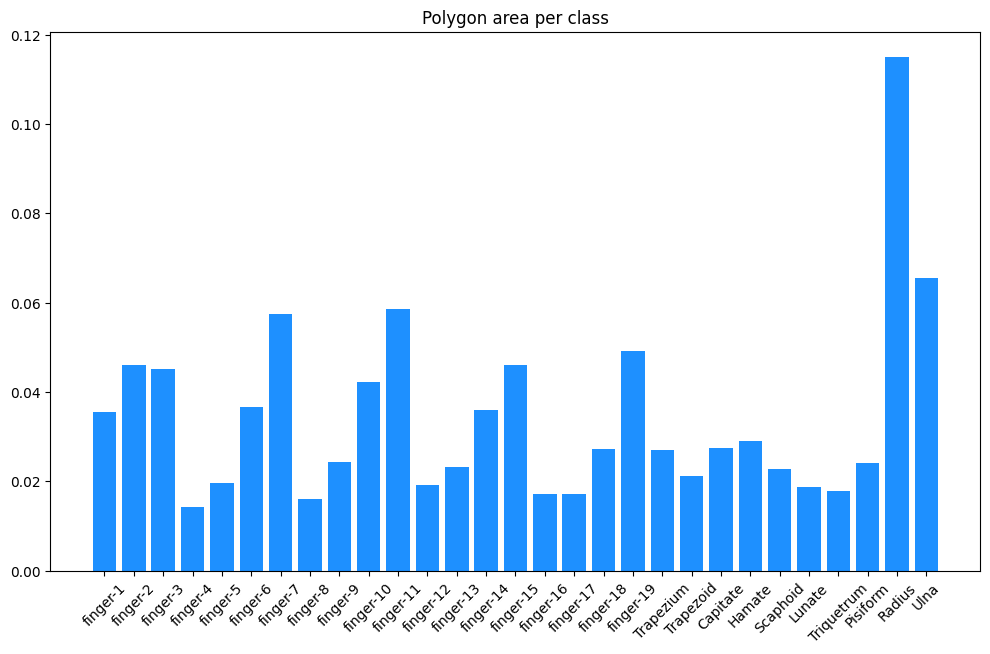

In [11]:
fig, ax = plt.subplots(figsize=(12, 7))
plt.title("Polygon area per class")
plt.bar([CLASSES[i] for i in range(29)], values, color="dodgerblue")
plt.xticks(rotation=45)
plt.show()

# process tabular data

In [12]:
table_path = "/opt/ml/input/data/meta_data.xlsx"
table = pd.read_excel(table_path)

In [13]:
(table["성별"]).value_counts()

성별
_x0008_여    269
_x0008_남    243
남            11
여            10
 여            9
 남            8
Name: count, dtype: int64

In [14]:
table["성별"] = ["male" if "남" in sex else "female" for sex in table["성별"] ]

In [15]:
total_list=[]
for key in ["male", "female"]:
    data_list=[]
    for i in table[table["성별"]==key]["ID"]:
        path = "/opt/ml/input/data/train/outputs_json/ID"+str(i).zfill(3)
        try:
            for img in os.listdir(path):
                json_path = os.path.join(path, img)
                with open(json_path, "r") as f:
                    temp = json.load(f)
                    values=[]
                    for i in range(len(temp["annotations"])):
                        points = np.array(temp["annotations"][i]["points"])
                        values.append(PolyArea(points[:, 0], points[:, 1])) 
                    data_list.append(values)
        except Exception as e:
            pass
    total_list.append(data_list)

In [16]:
maledf = pd.DataFrame(total_list[0])
femaledf = pd.DataFrame(total_list[1])

male_info = maledf.describe()
female_info = femaledf.describe()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


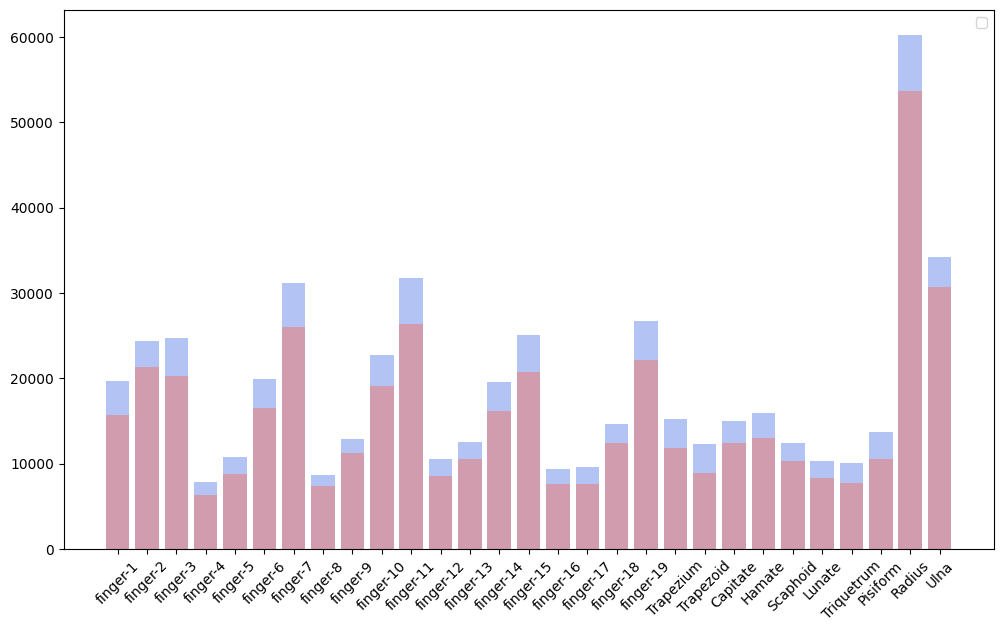

In [17]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.bar([CLASSES[i] for i in range(29)], male_info.loc["mean"], color="royalblue", alpha=0.4)
ax.bar([CLASSES[i] for i in range(29)], female_info.loc["mean"], color="tomato", alpha=0.4)

# ax.bar(male_info.columns, male_info.loc["mean"], width=width, label="male")
plt.xticks(rotation=45)
ax.legend()